https://huggingface.co/transformers/_modules/index.html

In [ ]:
# For Google Colaboratory
 
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
 
    path_to_file = '/content/gdrive/My Drive/AI Sem II/NLP/Project Test'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/AI Sem II/NLP/Project Test/transformers-coqa-master
/content/gdrive/My Drive/AI Sem II/NLP/Project Test/transformers-coqa-master


In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install -U spacy


  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4ptzcvau
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-4ptzcvau
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 13.0MB/s 
     |████████████████████████████████| 901kB 53.9MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2122482 sha256=fcc28d06f05e560853fcc473921b0b4e7a04b9ea2c44c41715d56bddb3765c1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-r14e3qu0/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
     |████████████████████████████████| 12.8MB 11.1MB/s 
     |████████████████████████████████| 460kB 64.3MB/s 
     |████████████████████████████████| 1.1MB 52.4MB/s 
     |████████████████████████████████| 9.1MB 53.3MB/s 
     |███████████████

In [ ]:
import torch
import string
import transformers
import re
from tqdm import tqdm, trange
import spacy 
import spacy.cli
import logging
import collections
from collections import Counter
import math
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from transformers import BertModel, BertTokenizer, AdamW
#from pytorch_pretrained_bert.modeling import BertModel, BertPretrainedModel
#from pytorch_pretrained_bert.tokenization import BertTokenizer
#from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
#from pytorch_ptrtrained_bert.tokenization import BasicTokenizer, whitespace_tokenize
from transformers.models.bert.tokenization_bert import BasicTokenizer

import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import json
spacy.cli.download('en')
spacy.load('en_core_web_sm')
import random
import numpy as np
import pickle
import os
import matplotlib as pplot

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 12.8MB/s 


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
#from transformers.models.roberta.tokenization_roberta import RobertaTokenizer
#import sentencepiece
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
from transformers.models.albert.tokenization_albert import AlbertTokenizer
bert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
#model =BertModel.from_pretrained('bert-base-uncased')
output_directory = 'outputs'

# If output directory doesn't exist create one
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [ ]:
#Class to store questions, their answers along with the starting index of the answer and end index of answer and tokens in the story
class QA(object):
  def __init__(
            self,
            question_answer_id,
            question_text,
            document_tokens,
            original_answer_text=None,
            answer_start_position=None,
            answer_end_position=None,
            additional_answers=None,
    ):
    self.question_answer_id = question_answer_id
    self.question_text = question_text
    self.document_tokens = document_tokens
    self.original_answer_text = original_answer_text
    self.answer_start_position = answer_start_position
    self.answer_end_position = answer_end_position
    self.additional_answers = additional_answers

# Class to store features, input ids, input mask, segment ids, start positions, end positions, etc
class DataFeatures(object):
  def __init__(self,
                 unique_id,
                 example_index,
                 document_span_index,
                 tokens,
                 token_to_origin_mapping,
                 token_max_context,
                 input_ids,
                 input_mask,
                 segments,
                 start_position=None,
                 end_position=None,
                 class_index=None):            
    self.unique_id = unique_id
    self.example_index = example_index
    self.document_span_index = document_span_index
    self.tokens = tokens
    self.token_to_origin_mapping = token_to_origin_mapping
    self.token_max_context = token_max_context
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segments = segments
    self.start_position = start_position
    self.end_position = end_position
    self.class_index = class_index


# Function to read COQA datasets and process the data
def get_data_from_coqa(isTrain, input_file, history_len=2, add_QA_tag=False):

# Check if the character is a white space
  def check_whitespace(char):
        if char == " " or char == "\t" or char == "\r" or char == "\n" or ord(char) == 0x202F:
            return True
        return False

# Token conversion
  def tokenize_string(str):
        if (str.lower() == '-lrb-'):
            str = '('
        elif (str.lower() == '-rrb-'):
            str = ')'
        elif (str.lower() == '-lsb-'):
            str = '['
        elif (str.lower() == '-rsb-'):
            str = ']'
        elif (str.lower() == '-lcb-'):
            str = '{'
        elif (str.lower() == '-rcb-'):
            str = '}'
        return str

  def space_extension(matchobject):
    return ' ' + matchobject.group(0) + ' '  

 # Preprocessing 
  def pre_processing(word):
    word = re.sub(
        u'-|\u2010|\u2011|\u2012|\u2013|\u2014|\u2015|%|\[|\]|:|\(|\)|/|\t',
        space_extension, word)
    word = word.strip(' \n')
    word = re.sub('\s+', ' ', word)
    return word

  # Process text to return output as words with their indexes in the sentences 
  def processing(main_text):
          processed_text = {'word': [], 'offsets': [], 'sentences': []}
 
          for token in main_text:
              processed_text['word'].append(tokenize_string(token.text))
              processed_text['offsets'].append((token.idx, token.idx + len(token.text)))
          #print("=======offset is", (token.idx, token.idx + len(token.text)), "=====word is", tokenize_string(token.text))

          word_index = 0
          for sentence in main_text.sents:
              processed_text['sentences'].append((word_index, word_index + len(sentence)))
              word_index += len(sentence)
          #print("=======sentence is",  word_index, word_index + len(sentence) )

          assert word_index == len(processed_text['word'])
           
          return processed_text

  # Get the context offsets
  def context_offsets(words, raw_text):
    #print(words, raw_text)
    raw_text_context_offsets = []
    r = 0
    for token in words:
        while r < len(raw_text) and re.match('\s', raw_text[r]):
            r += 1
        if raw_text[r:r + len(token)] != token:
            print('Error', token, 'Raw Text:', raw_text)

        raw_text_context_offsets.append((r, r + len(token)))
        r += len(token)
 
    return raw_text_context_offsets

  # Function to find span with start and end index provided
  def define_span_indices(offsets, start_pos, end_pos):
     
    span_start_index = -1
    span_end_index = -1
    #print("offset is", offsets)
    for i, offset in enumerate(offsets):
        if (span_start_index < 0) or (start_pos >= offset[0]):
            span_start_index = i
        if (span_end_index < 0) and (end_pos <= offset[1]):
            span_end_index = i
    #print("span",span_start_index, span_end_index)
    return (span_start_index, span_end_index)

# Removing punctuations, lowering texts and removing extra white spaces
  def pre_process_answer(s):
    
    
    # Remove articles from the text
    def remove_articles(text):
        reg_expression = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(reg_expression, ' ', text)
    
    # Remove white spaces from the text
    def adjust_white_space(text):
        return ' '.join(text.split())

    # Remove punctuations from the text
    def remove_punctuations(text):
        rem = set(string.punctuation)
        return ''.join(c for c in text if c not in rem)

    # Lower the text characters
    def lowering_text(text):
        return text.lower()
     

    return adjust_white_space(remove_articles(remove_punctuations(lowering_text(s))))  

# Find the span providing the context and offsets  
  def span_with_ground_truth(context, offsets, ground_truth):

    best_F1 = 0.0
    best_span = (len(offsets) - 1, len(offsets) - 1)
    ground_truth_temp = pre_process_answer(pre_processing(ground_truth)).split()

    ls = [
        i for i in range(len(offsets))
        if context[offsets[i][0]:offsets[i][1]].lower() in ground_truth
    ]

    for i in range(len(ls)):
        for j in range(i, len(ls)):
            prediction = pre_process_answer(
                pre_processing(
                    context[offsets[ls[i]][0]:offsets[ls[j]][1]])).split()
            common = Counter(prediction) & Counter(ground_truth_temp)
            num_same = sum(common.values())

            #print(num_same, "common span")
            if num_same > 0:
                precision = 1.0 * num_same / len(prediction)
                recall = 1.0 * num_same / len(ground_truth_temp)
                F1 = (2 * precision * recall) / (precision + recall)
                if F1 > best_F1:
                    best_F1 = F1
                    best_span = (ls[i], ls[j])
     
    #print(best_span, "best span")

    return best_span

  nlp = spacy.load("en_core_web_sm")
  # Read training file
  with open(input_file, "r", encoding='utf-8') as reader:
        input_text_file = json.load(reader)["data"]
  print(len(input_text_file))
  samples = []
  input_text_file = input_text_file 
############################################################
############################################################
############################################################
  if isTrain:
    data_len =  len(input_text_file) # Restricted training data due to hardware limitations
  else:
    data_len =  len(input_text_file) # Entire Development Data is loaded 
  number_yes = 0
  number_no = 0
  number_unknown = 0
  number_span = 0 
  number_nonespan = 0 
  # Fetch and store story, questions and answers after processing the text
  for data_index in tqdm(range(data_len), desc='Generating examples'):
    input_data = input_text_file[data_index]
    context_string = input_data['story']
    input_data_object = {
        'context': context_string,
        'source': input_data['source'],
        'id': input_data['id'],
        'filename': input_data['filename']
    }
     
     
    nlp_context = nlp(pre_processing(context_string)) 
     
    input_data_object['annotated_context'] = processing(nlp_context)
     
    input_data_object['raw_context_offsets'] = context_offsets(
          input_data_object['annotated_context']['word'], context_string)
      
    assert len(input_data['questions']) == len(input_data['answers'])
    additional_answers = {} 
    if 'additional_answers' in input_data:
      for k, answer in input_data['additional_answers'].items():
        if len(answer) == len(input_data['answers']):
          for example in answer:
            index = example['turn_id']
            if index not in additional_answers:
              additional_answers[index] = []
            additional_answers[index].append(example['input_text'])
    
    
    for i in range(len(input_data['questions'])):
      question, answer = input_data['questions'][i], input_data['answers'][i]
      assert question['turn_id'] == answer['turn_id']
       

      index = question['turn_id']
      _qas = {
          'turn_id': index,
          'question': question['input_text'],
          'answer': answer['input_text']
      }
       
      if index in additional_answers:
        _qas['additional_answers'] = additional_answers[index]
      _qas['raw_answer'] = answer['input_text']
      
      if _qas['raw_answer'].lower() in ['yes', 'yes.']:
        _qas['raw_answer'] = 'yes'
        number_yes =  number_yes+1
      if _qas['raw_answer'].lower() in ['no', 'no.']:
        
        _qas['raw_answer'] = 'no'
        number_no =number_no +1
      if _qas['raw_answer'].lower() in ['unknown', 'unknown.']:
        
        _qas['raw_answer'] = 'unknown'  
        number_unknown = number_unknown+1     
      _qas['answer_span_start'] = answer['span_start']
      _qas['answer_span_end'] = answer['span_end']
       
      start = answer['span_start']
      end = answer['span_end']
      chosen_text = input_data_object['context'][start:end].lower()
      
      while len(chosen_text) > 0 and check_whitespace(chosen_text[0]):
        chosen_text = chosen_text[1:]
        start += 1
       
      while len(chosen_text) > 0 and check_whitespace(chosen_text[-1]):
        chosen_text = chosen_text[:-1]
        end -= 1
        
      
      input_text = _qas['answer'].strip().lower() 
      if input_text in chosen_text:
        #print(input_text, "=====",chosen_text)
        input_text = _qas['answer'].strip().lower() 
        number_span = number_span+1
        p = chosen_text.find(input_text)
         
        #get the answer span from raw text when the answer can be extracted exactly
        _qas['answer_span'] = define_span_indices(input_data_object['raw_context_offsets'],
                                                start + p,
                                                start + p + len(input_text))
        #print(input_data_object['raw_context_offsets'])
        #_qas['raw_long_question'] = question['input_text']
###########################here remove the else to every question)
      else:
#########################################################################
        input_text = answer['span_text'].strip().lower()
        number_nonespan =number_nonespan +1 
#########################################################################
         
        _qas['answer_span'] = span_with_ground_truth(
                      input_data_object['context'], input_data_object['raw_context_offsets'],
                      input_text)
        #look back maximumly 2 questions 
     
      long_question = ''
      for j in range(i - history_len, i + 1):
           if j < 0:
             continue
           long_question += (' <Q> ' if add_QA_tag else
                                  ' ') + input_data['questions'][j]['input_text']
           
           if j < i:
                    long_question += (' <A> ' if add_QA_tag else
                                      ' ') + input_data['answers'][j]['input_text']
           
           long_question = long_question.strip()
############################################################################################################################################################################           
           #add question history 
           #print(long_question)
           _qas['raw_long_question'] = long_question
############################################################################################################################################################################
           
           _qas['annotated_long_question'] = processing(
                nlp(pre_processing(long_question)))
           #offset is the letter position of the word
   # Store questions along with their answers     
      sample = QA(
                question_answer_id =input_data_object['id'] + ' ' + str(_qas['turn_id']),
                question_text =_qas['raw_long_question'],
                document_tokens =input_data_object['annotated_context']['word'],
                original_answer_text =_qas['raw_answer'],
                answer_start_position =_qas['answer_span'][0],
                answer_end_position =_qas['answer_span'][1],
                additional_answers=_qas['additional_answers'] if 'additional_answers' in _qas else None,
                )
      
      samples.append(sample)
  print("yes",number_yes,"no", number_no, "unknown",number_unknown,"span",number_span, number_nonespan)
      #print(sample.question_answer_id, sample.question_text, sample.original_answer_text,  sample.answer_start_position, sample.answer_end_position, sample.additional_answers )#, sample.question_text,sample.original_answer_text)
  return samples

In [ ]:

# Read CoQA training file, Needs to provide the training file path here
training_samples = get_data_from_coqa(True, input_file="data/coqa-train-v1.0.json", history_len= 2, add_QA_tag= False)
#print(training_samples)

Generating examples:   0%|          | 0/5 [00:00<?, ?it/s]

7199


Generating examples: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]

yes 5 no 5 unknown 1 span 53 22


In [ ]:

# Function to improve the answer by modifying the start and end indexes to appropriate answer
def modify_answer_span(document_tokens, input_start_index, input_end_index, tokenizer, original_answer_text):
  #print(document_tokens, input_start_index, input_end_index, tokenizer, original_answer_text)
  token_answer_text = " ".join(bert_tokenizer.tokenize(original_answer_text))
  
  # loop to modify the indexes for appropriate answer
  for new_start_index in range(input_start_index, input_end_index + 1):
    for new_end_index in range(input_end_index, new_start_index - 1, -1):
      text_span = " ".join(document_tokens[new_start_index:(new_end_index + 1)])
      if text_span == token_answer_text:
        return (new_start_index, new_end_index)
  
 
  return (input_start_index, input_end_index)

# Function to select the span with the maximum context for the token
def check_max_context(document_spans, current_span_index, current_position):
   
  best_score = None
  best_span_index = None
  for (span_index, document_span) in enumerate(document_spans):
    end = document_span.start + document_span.length - 1
    if current_position < document_span.start:
            continue
    if current_position > end:
            continue
    left_context = current_position - document_span.start
    right_context = end - current_position
    score = min(left_context, right_context) + 0.01 * document_span.length # Score calculation for the current start and end index
    if best_score is None or score > best_score:  # selection of indexes based on better score
      best_score = score
      best_span_index = span_index
  
  return current_span_index == best_span_index
# Function to convert CoQA Data to features
def converting_examples_into_features(examples, tokenizer, maximum_sequence_length, document_stride, maximum_query_length):
   
  unique_id = 1000000000
  features = []
  for (example_index, example) in enumerate(tqdm(examples, desc="Generating features for CoQA...")):
    query_token = tokenizer.tokenize(example.question_text)
     
    class_index = 3

    # Check for the type of answer whether it is yes/no type otherwise set to unknown
    if example.original_answer_text == 'yes':
      class_index = 0  
    elif example.original_answer_text == 'no':
      class_index = 1 
    elif example.original_answer_text == 'unknown':
      class_index = 2  
  
    # Check for the length of the query and select the query until uth maximum query length set
    if len(query_token) > maximum_query_length:
      query_token = query_token[0:maximum_query_length]
    
    token_to_original_index = []
    original_to_token_index = []
    all_document_tokens = []

    for (i, token) in enumerate(example.document_tokens):
      original_to_token_index.append(len(all_document_tokens))
      sub_tokens = tokenizer.tokenize(token)
      for sub_token in sub_tokens:
        token_to_original_index.append(i)
        all_document_tokens.append(sub_token)
     
    token_start_position = None
    token_end_position = None
    if class_index < 3:
      token_start_position, token_end_position = 0,0
    else:
      token_start_position = original_to_token_index[example.answer_start_position]
      if example.answer_end_position < len(example.document_tokens) - 1:
        token_end_position = original_to_token_index[example.answer_end_position + 1] - 1
      else:
        token_end_position = len(all_document_tokens) - 1
      (token_start_position, token_end_position) = modify_answer_span(
                all_document_tokens, token_start_position, token_end_position, tokenizer,
                example.original_answer_text)
    
     
    maximum_tokens_for_document = maximum_sequence_length - len(query_token) - 3
     
    _DocSpan = collections.namedtuple(  
            "DocSpan", ["start", "length"])
 ######################################################################need to figure out this##################################    
    document_spans = []
    start_offset = 0
    while start_offset < len(all_document_tokens):
      length = len(all_document_tokens) - start_offset
      if length > maximum_tokens_for_document:
        length = maximum_tokens_for_document
      document_spans.append(_DocSpan(start=start_offset, length=length))
      if start_offset + length == len(all_document_tokens):
        break
      start_offset += min(length, document_stride)
      
    
    # loop to add the seperator tokens in the input sequence
    for (document_span_index, document_span) in enumerate(document_spans):   
      slice_class_index = class_index
      tokens = []
      token_to_origin_mapping = {}
      token_max_context = {}
      segment_ids = []
      tokens.append("[CLS]")
      segment_ids.append(0)
      
      for token in query_token:
          
          tokens.append(token)
          segment_ids.append(0)
      #this is for single query examples
      tokens.append("[SEP]")

      segment_ids.append(0)
       
      for i in range(document_span.length):
        split_token_index = document_span.start + i
        token_to_origin_mapping[len(
                    tokens)] = token_to_original_index[split_token_index]
        is_max_context = check_max_context(document_spans,
                                                       document_span_index,
                                                       split_token_index)
        token_max_context[len(tokens)] = is_max_context
        tokens.append(all_document_tokens[split_token_index])
        segment_ids.append(1)
      #this merges the entire paragraph
      tokens.append("[SEP]")
      segment_ids.append(1)
       
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      
      input_mask = [1] * len(input_ids)
       

      while len(input_ids) < maximum_sequence_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
      #print(input_ids, input_mask,segment_ids )
      assert len(input_ids) == maximum_sequence_length
      assert len(input_mask) == maximum_sequence_length
      assert len(segment_ids) == maximum_sequence_length

      # Start and end position calculations
      start_position = None
      end_position = None
      if class_index >= 3:
        document_start = document_span.start
        document_end = document_span.start + document_span.length - 1
         
        out_of_span = False
  
      
        if not (token_start_position >= document_start
                        and token_end_position <= document_end):
           
          out_of_span = True
        if out_of_span:
          start_position = 0
          end_position = 0
          slice_class_index = 2
        else: #why use document offest
          document_offset = len(query_token) + 2
          start_position = token_start_position - document_start + document_offset
          end_position = token_end_position - document_start + document_offset
          
      else:
        start_position = 0
        end_position = 0
      
      # add the current feature calculated to the features list   
      features.append(                            
          DataFeatures(unique_id=unique_id, #record id
                        example_index=example_index, #question id
                        document_span_index=document_span_index,#document id
                        tokens=tokens,#tokens for the entire questions and context texts
                        token_to_origin_mapping=token_to_origin_mapping, #mapping the sequence with original index
                        token_max_context=token_max_context,#whether exceed the maximum length
                        input_ids=input_ids,#the tokenizer word embedding
                        input_mask=input_mask,#the mask for all tokens, with word is 1, the rest padded with 0, 450
                        segments=segment_ids,#segments of historical question and answer 0, context 1 
                        start_position=start_position,#start position of the answer span
                        end_position=end_position,#end position of the answer span
                        class_index=slice_class_index)) #whether yes, no, unknow, or usual
     
      unique_id += 1
       
  return features  # Return all the features


In [ ]:

training_data_features = converting_examples_into_features(
                examples=training_samples,
                tokenizer=bert_tokenizer,
                maximum_sequence_length=450,
                document_stride=128,
                maximum_query_length=75,
            )

Generating features for CoQA...: 100%|██████████| 75/75 [00:01<00:00, 52.73it/s]


In [ ]:
# Tensor construction for input ids
dataset_input_ids = torch.tensor([f.input_ids for f in training_data_features], dtype=torch.long)
print(dataset_input_ids)

# Tensor construction for input masks
dataset_input_masks = torch.tensor([f.input_mask for f in training_data_features], dtype=torch.long)
print(dataset_input_masks)

# Tensor construction for segment ids
dataset_segment_ids = torch.tensor([f.segments for f in training_data_features], dtype=torch.long)
print(dataset_segment_ids)

#Tensor construction for start positions
dataset_start_positions = torch.tensor([f.start_position for f in training_data_features], dtype=torch.long)
print(dataset_start_positions)

#Tensor construction for end positions
dataset_end_positions = torch.tensor([f.end_position for f in training_data_features], dtype=torch.long)
print(dataset_end_positions)

dataset_class_index = torch.tensor([f.class_index for f in training_data_features], dtype=torch.long)


# Wrapping tensors in a tensor dataset
training_data = TensorDataset(dataset_input_ids, dataset_input_masks, dataset_segment_ids, dataset_start_positions, dataset_end_positions,dataset_class_index)
torch.save(training_data, 'outputs/train_tensor_albert_base_16.pt')
training_data_save = torch.load('outputs/train_tensor_albert_base_16.pt')
print(training_data_save)

# Train sampler to return random indices
training_data_sampler = RandomSampler(training_data_save)
#training_data_sampler = SequentialSampler(training_data_save)
print(training_data_sampler)

# Creating python iterable over tensor datasets
training_dataloader = DataLoader(training_data_save, sampler=training_data_sampler, batch_size=8) # has to be little else the server will have runtime out error
print(training_dataloader)
from math import *

tensor([[   2,   76,   23,  ...,    0,    0,    0],
        [   2,   76,   23,  ...,    0,    0,    0],
        [   2,   76,   23,  ...,    0,    0,    0],
        ...,
        [   2,   17,   72,  ...,    0,    0,    0],
        [   2,   23,   39,  ..., 3571,   13,    3],
        [   2,   23,   39,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([ 48, 136, 137, 141, 196, 254, 262,  25,  57, 121, 247, 271, 176,   0,
        183, 177,  62, 331, 214, 229,  77,  75, 114, 361, 378, 238,  50,   0,
          0,  90,   0,   0, 148,   0, 175,  47, 165,  37, 188,   0,   0, 236,
    

Some weights of the model checkpoint at albert-base-v2 were not used when initializing CoQAwithAlbert: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing CoQAwithAlbert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CoQAwithAlbert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CoQAwithAlbert were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['linear.weight', 'linear.bias', 'qa_outputs.weight', 'qa_outputs.bias', 'class_outputs.weight', 'class_outputs.bias

7.565906524658203



Iteration:  13%|█▎        | 2/15 [00:00<00:03,  4.01it/s]

7.532534599304199



Iteration:  20%|██        | 3/15 [00:00<00:02,  4.05it/s]

7.558341026306152



Iteration:  27%|██▋       | 4/15 [00:00<00:02,  4.07it/s]

7.570143699645996



Iteration:  33%|███▎      | 5/15 [00:01<00:02,  4.09it/s]

7.524482250213623



Iteration:  40%|████      | 6/15 [00:01<00:02,  4.10it/s]

7.536935806274414



Iteration:  47%|████▋     | 7/15 [00:01<00:01,  4.11it/s]

7.542910099029541



Iteration:  53%|█████▎    | 8/15 [00:01<00:01,  4.12it/s]

7.552838325500488



Iteration:  60%|██████    | 9/15 [00:02<00:01,  4.12it/s]

7.568912029266357



Iteration:  67%|██████▋   | 10/15 [00:02<00:01,  4.12it/s]

7.568861484527588



Iteration:  73%|███████▎  | 11/15 [00:02<00:00,  4.12it/s]

7.551202774047852



Iteration:  80%|████████  | 12/15 [00:02<00:00,  4.12it/s]

7.559648513793945



Iteration:  87%|████████▋ | 13/15 [00:03<00:00,  4.11it/s]

7.546690940856934



Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

7.507542610168457
7.5691375732421875


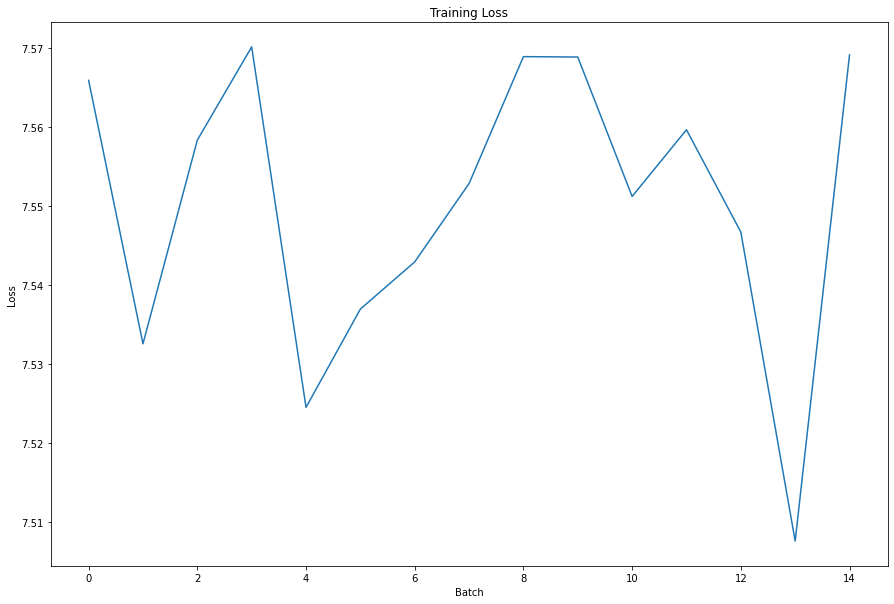

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from transformers import AlbertModel,AlbertConfig    
from transformers import AlbertModel, AdamW, AlbertConfig
AlbertPreTrainedModel = transformers.AlbertPreTrainedModel 
# Model creation using Bert Pretrained Model as a base
class CoQAwithAlbert(AlbertPreTrainedModel):

  # Configurations passed to BERT model
  def __init__(
            self,
            config,
            output_attentions=False,
            keep_multihead_output=False,
            class_alpha=1.0,
            mask_p=0.0,
    ):
    super(CoQAwithAlbert, self).__init__(config)
    self.class_alpha = class_alpha
    self.mask_p = mask_p
    self.albert = AlbertModel(
    config,
    )
    self.linear = nn.Linear(config.hidden_size,config.hidden_size)
    self.relu  = nn.ReLU()
  
    self.qa_outputs = nn.Linear(config.hidden_size, 2)
    self.output_attentions = False
    self.class_outputs = nn.Linear(config.hidden_size, 4)
    model_config = AlbertConfig.from_pretrained('albert-base-v2', output_hidden_states=True)
    self.albert = AlbertModel.from_pretrained('albert-base-v2', config=model_config)
    #self.apply(self.init_bert_weights)
    #self.apply(self.init_bert_weights)
  
  # Forward pass for the BERT model
  def forward(
            self,
            input_ids,  # Input seq indices 
            token_type_ids=None,
            attention_mask=None, # Masking to avoid attention
            start_positions=None, # Starting position of the span
            end_positions=None,  # End position of the span
            class_index = None,
    ):
    outputs = self.albert(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            #head_mask=head_mask,
        )
     
    # outputs consists of the elements based on the configurations provided to BERT
    sequence_output= outputs[0]
    class_outputs = outputs[1] 
    
    span_logits_0 = self.linear(sequence_output)
    span_logits_0 =self.relu(span_logits_0)  
    span_logits_0 = self.linear(span_logits_0)
    span_logits_0 =self.relu(span_logits_0)  
    span_logits = self.qa_outputs(span_logits_0)
    
    class_logits_0 = self.linear(class_outputs)
    class_logits_0 =self.relu(class_logits_0 )  
    class_logits_0 = self.linear(class_logits_0 )
    class_logits_0 =self.relu(class_logits_0 )  

    class_logits = self.class_outputs(class_logits_0)
    #print(span_logits_0.shape, class_logits_0.shape)
    start_logits, end_logits = span_logits.split(1, dim=-1)
    start_logits = start_logits.squeeze(-1)
    end_logits = end_logits.squeeze(-1)
    #print(class_logits.shape)

    # Span extraction based on start positions and end positions
    if start_positions is not None and end_positions is not None:
      if len(start_positions.size()) > 1:
        start_positions = start_positions.squeeze(-1)
      if len(end_positions.size()) > 1:
        end_positions = end_positions.squeeze(-1)
      ignored_index = start_logits.size(1)
       
      start_positions.clamp_(0, ignored_index)
      end_positions.clamp_(0, ignored_index)
      #print(start_logits.shape, start_positions)
      #print(end_logits, end_positions)
      span_loss_factor = CrossEntropyLoss(ignore_index=ignored_index)
      class_loss_factor = CrossEntropyLoss()
      #here need to have the argmax for start_logits
      #this loss is still based on the text span, there is no text generation component, need to see more how others do this piece, the model is not quite right
      #data preprocessing done, but there is no ground truth answer therefore can't train, refer to other models, or otherwise this is still using squad method to do coqa
      start_loss = span_loss_factor(start_logits, start_positions)
      end_loss = span_loss_factor(end_logits, end_positions)
      class_loss = class_loss_factor(class_logits, class_index)
      #print(class_logits, class_index)
      #########################################################
      #########################################################
      #index = class_logits.data.cpu().numpy().argmax()
     #index_tensor = torch.argmax(class_logits)
      loss=0
      #add_loss =nn.L1Loss()
     # for i, index in enumerate(class_index):
     #   if index == torch.tensor(1).to(device):
          #print(class_logits[i].argmax(),index, "###############")
          #loss =  add_loss(class_logits[i].argmax()/index + 0.001,torch.tensor(1.0).to(device)+0.001).detach()
     #     loss = abs((class_logits[i].argmax()/index + 0.001)-(torch.tensor(1.0).to(device)+0.001))
          
     #   else:
     #     loss = 0
       
   
       
      ########################################################################################################
      total_loss = (start_loss + end_loss) / 2 + self.class_alpha * class_loss + 0.05* loss 
      
      return total_loss
    return start_logits, end_logits, class_logits
model1 = CoQAwithAlbert.from_pretrained('albert-base-v2', output_hidden_states=True)
 # Set model in training mode
device="cuda"
model1.to(device)
model1.train()

#for albert
RawResult = collections.namedtuple("RawResult",
                                   ["unique_id", "start_logits", "end_logits", "cls_logits"])

# Calculation for optimization steps accordingly training length, which will be used for learning rate for BERT model
train_optimization_steps = len(
            training_dataloader
        )

# Fetch the training hyperparameters
parameter_optimizer = list(model1.named_parameters())
parameter_optimizer = [n for n in parameter_optimizer if 'pooler' not in n[0]]
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in parameter_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in parameter_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]


# Load apex optimizers
optimizer = AdamW(optimizer_grouped_parameters,
                                  lr=3e-5)
#optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)


n_gpu = torch.cuda.device_count()
# Accuracy and loss for plotting
plot_data = []
for epoch in trange(1, desc="Epoch"): # Epoch provided: 3, restricted for now to avoid the memory issue but can be increased to improve the model
  for step, batch in enumerate(
          tqdm(training_dataloader,
                desc="Iteration",
                disable=-1 not in [-1, 0])):
    if n_gpu == 1: # check for gpu count 
          batch = tuple(
              t.to(device)
              for t in batch)
    # Get the batch data to be provided to the model
    dataset_input_ids,dataset_input_masks,dataset_segment_ids, dataset_start_positions, dataset_end_positions, dataset_class_index = batch
    loss = model1(dataset_input_ids, dataset_segment_ids, dataset_input_masks,
                    dataset_start_positions, dataset_end_positions, dataset_class_index)
     # Adding the loss to plot data to plot the graph in the end 
    loss.backward()
    plot_data.append(loss.detach().item())
    print(loss.detach().item())
    if step < 5000:
          lr_this_step = np.linspace(0, 3e-5, 5001)[1:]
          for param_group in optimizer.param_groups:
            param_group['lr'] = lr_this_step[step]
    else:
          param_group['lr']= (1+ cos(step*pi/len(training_dataloader)))*1/2*(3e-5)
    optimizer.step()
    optimizer.zero_grad()
    #global_step += 1
torch.save(model1, 'outputs/albert_base_8_2linear.pth')
import matplotlib.pyplot as pplot

# Graph plotting code X axis is Batch and Y axis is loss
pplot.figure(figsize= (15, 10))
pplot.title("Training Loss")
pplot.xlabel("Batch")
pplot.ylabel("Loss")
pplot.plot(plot_data)
pplot.savefig('outputs/albert_base_8_2linear.png', dpi=300, bbox_inches='tight')
pplot.show()

In [ ]:

# Read COQA Dev file, File path needs to be provided where COQA dev file is stored
testing_samples = get_data_from_coqa(False, input_file="data/coqa-dev-v1.0.json",
                                                history_len= 2,
                                                add_QA_tag= False)
# Converting the development examples to features
testing_features = converting_examples_into_features(
                examples=testing_samples,
                tokenizer=bert_tokenizer,
                maximum_sequence_length=450,
                document_stride=128,
                maximum_query_length=75,
            )
print(testing_features[0])
#Tensor construction for input ids
dataset_input_ids = torch.tensor([f.input_ids for f in testing_features], dtype=torch.long)
print(dataset_input_ids)

#Tensor construction for input masks
dataset_input_masks = torch.tensor([f.input_mask for f in testing_features], dtype=torch.long)
print(dataset_input_masks)

#Tensor construction for segment ids
dataset_segment_ids = torch.tensor([f.segments for f in testing_features], dtype=torch.long)
print(dataset_segment_ids)

dataset_example_index  = torch.arange(dataset_input_ids.size(0), dtype=torch.long)

# Wrapping tensors in a tensor dataset
testing_data = TensorDataset(dataset_input_ids, dataset_input_masks, dataset_segment_ids, dataset_example_index)
 
torch.save(testing_data, 'outputs/test_tensor_albert_base_16.pt')
testing_data_save = torch.load('outputs/test_tensor_albert_base_16.pt')
print(testing_data_save)
# Sampling the elements in the same order they are(sequentially)
testing_data_sampler = SequentialSampler(testing_data_save)
print(testing_data_sampler)

# Creating python iterable over tensor dataset
testing_dataloader = DataLoader(testing_data_save, sampler=testing_data_sampler, batch_size=8)
print(testing_dataloader) 

Generating examples:   0%|          | 0/1 [00:00<?, ?it/s]

500


Generating features for CoQA...:  50%|█████     | 6/12 [00:00<00:00, 53.05it/s]

yes 0 no 3 unknown 0 span 4 8


Generating features for CoQA...: 100%|██████████| 12/12 [00:00<00:00, 53.94it/s]

tensor([[   2,   98, 1665,  ...,    0,    0,    0],
        [   2,   98, 1665,  ...,    0,    0,    0],
        [   2,   98, 1665,  ...,    0,    0,    0],
        ...,
        [   2,   98,  144,  ...,    7,   13,    3],
        [   2,   98,  144,  ...,    0,    0,    0],
        [   2,  113,  144,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [ ]:
 
# Fetch the results for predictions using the trained model
results_for_predictions = []
for tqdm_input_ids, tqdm_input_mask, tqdm_segment_ids, tqdm_example_indices in tqdm(
                testing_dataloader,
                desc="Evaluation",
                disable=-1 not in [-1, 0]):
   
  tqdm_input_ids = tqdm_input_ids.to(device)
  tqdm_input_mask = tqdm_input_mask.to(device)
  tqdm_segment_ids = tqdm_segment_ids.to(device)

  # Get all the results from the model
  # Ensemble the results from Albert and BERT
  with torch.no_grad():
    model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = model1(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)  
    #model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = bert_i(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)  
    #model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = albert(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)  
    #model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = roberta(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)    
   # robertamodel_batch_start_logits, robertamodel_batch_end_logits, robertamodel_batch_cls_logits = roberta(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
   # bertmodel_batch_start_logits, bertmodel_batch_end_logits, bertmodel_batch_cls_logits = bert(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
   # albertmodel_batch_start_logits, albertmodel_batch_end_logits, albertmodel_batch_cls_logits = albert(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
  #model_batch_start_logits = (bertmodel_batch_start_logits +albertmodel_batch_start_logits)/2
  #model_batch_end_logits = (bertmodel_batch_end_logits+albertmodel_batch_end_logits)/2 
  #model_batch_cls_logits =(bertmodel_batch_cls_logits+ albertmodel_batch_cls_logits)/2
 
   
  # Get the start end logists from the model and store it in results
  for i, tqdm_example_index in enumerate(tqdm_example_indices):
    this_start_logits = model_batch_start_logits[i].detach().cpu().tolist()
    this_end_logits = model_batch_end_logits[i].detach().cpu().tolist()
    this_cls_logits = model_batch_cls_logits[i].detach().cpu().tolist()
    testing_feature = testing_features[tqdm_example_index.item()]
    unique_id = int(testing_feature.unique_id)
 
    # Store the prediction in the results list
    results_for_predictions.append(
                    RawResult(unique_id=unique_id,
                    start_logits= this_start_logits,
                    end_logits= this_end_logits,
                    cls_logits= this_cls_logits))

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 12.51it/s]


In [ ]:

op_pred_file = os.path.join(output_directory, "Output_Preds_albert_base_8_2linear.json")
output_nbest_file = os.path.join(output_directory, "nbest_predictions_albert_base_2linear.json") 
# Get the appropriate index for the answer text
def compute_best_indices(logits, n):
  index_with_score = sorted(enumerate(logits),
                             key=lambda x: x[1],
                             reverse=True)
   
  best_indices = []
  for i in range(len(index_with_score)):
    if i >= n:
      break
    best_indices.append(index_with_score[i][0])
  return best_indices
# Get the final text fetching it from the span using the predicted answer
def output_final_answer_text(predicted_text, original_text, low_case, v_log=False):
  def remove_spaces(text):
    non_space_chars = []
    non_space_char_to_space_char_map = collections.OrderedDict()
    for (i, c) in enumerate(text):
      if c == " ":
        continue
      non_space_char_to_space_char_map[len(non_space_chars)] = i
      non_space_chars.append(c)
    non_space_text = "".join(non_space_chars)
    return (non_space_text, non_space_char_to_space_char_map)

  # Get the BERT tokenizer to tokenize the text
  tokenizer = BasicTokenizer(do_lower_case=low_case)
  tokenized_text = " ".join(tokenizer.tokenize(original_text))

  # Find predicted text in the tokenized text to get the start and end positions
  start_position = tokenized_text.find(predicted_text)
  if start_position == -1:
      return original_text
  end_position = start_position + len(predicted_text) - 1

  # Remove spaces if any
  (original_non_space_text, original_non_space_to_space_map) = remove_spaces(original_text)
  (tokenized_non_space_text, tokenized_non_space_to_space_map) = remove_spaces(tokenized_text)

  if len(original_non_space_text) != len(tokenized_non_space_text):
    return original_text

  tokenized_non_space_to_space_map = {}
  for (i, _tokenized_index) in tokenized_non_space_to_space_map.items():
    tokenized_non_space_to_space_map[_tokenized_index] = i

  # Get the start position
  original_start_position = None
  if start_position in tokenized_non_space_to_space_map:
    non_space_start_position = tokenized_non_space_to_space_map[start_position]
    if non_space_start_position in original_non_space_to_space_map:
      original_start_position = original_non_space_to_space_map[non_space_start_position]
  
  # Check if the start position is None
  if original_start_position is None:
    return original_text

  # Get the End position
  original_text_end_position = None
  if end_position in tokenized_non_space_to_space_map:
    non_space_end_position = tokenized_non_space_to_space_map[end_position]
    if non_space_end_position in original_non_space_to_space_map:
      original_text_end_position = original_non_space_to_space_map[non_space_end_position]

  # Check if the end position is None
  if original_text_end_position is None:
    return original_text
  
  # Get the answer using start position and end position in the text
  final_output_text = original_text[original_start_position:(original_text_end_position + 1)]
  return final_output_text
# Calculates the probability of the span found
def compute_softmax_score(scores):
  if not scores:
    return []

  maximum_softmax_score = None
  for score in scores:
    if maximum_softmax_score is None or score > maximum_softmax_score:
      maximum_softmax_score = score

  expected_scores = []
  total_score_sum = 0.0
  for score in scores:
    x = math.exp(score - maximum_softmax_score)
    expected_scores.append(x)
    total_score_sum += x

  probabilities = []
  for score in expected_scores:
    probabilities.append(score / total_score_sum) # Probability calculation using the softmax score
  return probabilities

# Removing punctuations, lowering texts and removing extra white spaces
def normalize_answer1(s):
    
    # Remove articles from the text
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    
    # Remove white spaces from the text
    def white_space_fix(text):
        return ' '.join(text.split())

    # Remove punctuations from the text
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    # Lower the text characters
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# Check if the predictions are numbers or boolean values then set those to string equivalent
def confirm_predictions(json_best_predictions):
  # Number strings that will be used to represent numbers in the answers instead of actual numbers
  subs = ['one', 'two', 'three','four','five','six','seven','eight','nine','ten','eleven','twelve','true','false']
  original = json_best_predictions[0]['text']
  if len(original) < 2:
    for e in json_best_predictions[1:]:
      if normalize_answer1(e['text']) in subs:
        return e['text']
    return 'unknown'
  return original
# Function to Predict answers and write those predictions to predictions file 
def predict_answers(test_samples, test_sample_features, results_for_predictions, best_size,
                  maximum_answer_length, low_case, op_pred_file, v_log,
                  null_score_threshold):
  
  ex_index_to_feat_index = collections.defaultdict(list)
  
  # Create the dictionary of all the features in test features keeping feature index as key
  for feature in test_sample_features:
    ex_index_to_feat_index[feature.example_index].append(feature)
 
  ids_for_results = {}
  for result in results_for_predictions:
    ids_for_results[result.unique_id] = result
   
  # Naming the tuples for predictions
  Preliminary_Predictions = collections.namedtuple(
      "Preliminary_Predictions", [
                           "feature_index",
                           "start_index",
                           "end_index",
                           "start_logit",
                           "end_logit",
                           "class_logit",
                           "class_index",
      ])
  
  complete_predictions = []
  best_n_predictions_json = collections.OrderedDict() #in this case best 30 predictions
  prediction_scores_json = collections.OrderedDict()
  
  for (example_index, example) in enumerate(
      tqdm(test_samples, desc="Predicting...")):
    features = ex_index_to_feat_index[example_index]
     
    preliminary_predictions = []

    part_preliminary_predictions = []

    # Indices initialization
    score_of_answer_yes, score_of_answer_no, score_span, score_of_no_answer = -float('INF'), -float('INF'), -float('INF'), float('INF')

    
    minimum_no_answer_feature_index, maximum_yes_feature_index, maximum_no_feature_index, maximum_span_feature_index = 0, 0, 0, 0
    max_span_start_indexes, max_span_end_indexes = [], []
     
    # get the best start and end indices
    for (feature_index, feature) in enumerate(features):
       
      result = ids_for_results[feature.unique_id]
      # check the score for each class and determine the output yes, no, or span, or unknown 
      feature_yes_score, feature_no_score, feature_noanswer_score, feature_span_score = result.cls_logits 
       
      if feature_noanswer_score < score_of_no_answer:
        score_of_no_answer = feature_noanswer_score
        minimum_no_answer_feature_index = feature_index
      if feature_yes_score > score_of_answer_yes:
        score_of_answer_yes = feature_yes_score
        maximum_yes_feature_index = feature_index
      if feature_no_score > score_of_answer_no:
        score_of_answer_no = feature_no_score
        maximum_no_feature_index = feature_index
      # Here hasn't assign the correct class yet
      if feature_span_score > score_span:
        score_span = feature_span_score
        maximum_span_feature_index = feature_index
        start_indices = compute_best_indices(result.start_logits,
                                                  best_size)
        end_indices = compute_best_indices(result.end_logits, best_size)
        maximum_span_start_indices, maximum_span_end_indices = start_indices, end_indices
      
         
    
    preliminary_predictions.append(
        Preliminary_Predictions(feature_index=minimum_no_answer_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_no_answer,
                                class_index=2))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_yes_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_answer_yes,
                                class_index=0))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_no_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_answer_no,
                                class_index=1))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_span_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_span,
                                class_index=3))
   
    feature = features[maximum_span_feature_index]
    for start_index in maximum_span_start_indices:
      for end_index in maximum_span_end_indices:
        
        if start_index >= len(feature.tokens):
          continue
        if end_index >= len(feature.tokens):
          continue
        if start_index not in feature.token_to_origin_mapping:
          continue
        if end_index not in feature.token_to_origin_mapping:
          continue
        if not feature.token_max_context.get(start_index, False):
          continue
        if end_index < start_index:
          continue
        length = end_index - start_index + 1
        if length > maximum_answer_length:
          continue
        
        part_preliminary_predictions.append(
                      Preliminary_Predictions(
                          feature_index=maximum_span_feature_index,
                          start_index=start_index,
                          end_index=end_index,
                          start_logit=ids_for_results[
                              feature.unique_id].start_logits[start_index],
                          end_logit=ids_for_results[
                              feature.unique_id].end_logits[end_index],
                          class_logit=score_span,
                          class_index=3))
    ##this is to sort the largest score value for start and end pair    
    part_preliminary_predictions = sorted(
              part_preliminary_predictions,
              key=lambda p: p.start_logit + p.end_logit,
              reverse=True)
    ##this is to sort the largest score value for class 
    preliminary_predictions = sorted(preliminary_predictions,
                                      key=lambda p: p.class_logit,
                                      reverse=True)
    
    Best_Predictions = collections.namedtuple(  
              "Best_Predictions",
              ["text", "start_logit", "end_logit", "class_logit", "class_index"])
    
    known_predictions = {}
    best = []
    class_rank = []
    for prediction in part_preliminary_predictions:
      if len(best) >= best_size:
        break
      feature = features[prediction.feature_index]
      if prediction.class_index == 3:
        tokenized_tokens = feature.tokens[prediction.start_index:(prediction.end_index + 1)]
        original_document_start = feature.token_to_origin_mapping[prediction.start_index]
        original_document_end = feature.token_to_origin_mapping[prediction.end_index]
        original_tokens = example.document_tokens[original_document_start:(original_document_end + 1)]
        
        tokenized_text = " ".join(tokenized_tokens)

        tokenized_text = tokenized_text.replace(" ##", "")
        tokenized_text = tokenized_text.replace("##", "")

        tokenized_text = tokenized_text.strip()
        tokenized_text = " ".join(tokenized_text.split())
        original_text = " ".join(original_tokens)

        final_output_text = output_final_answer_text(tokenized_text, original_text, low_case, v_log)
         
        if final_output_text in known_predictions:
          continue

        known_predictions[final_output_text] = True
        best.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=prediction.start_logit,
                                      end_logit=prediction.end_logit,
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
    
    # Writing the approriate answers in predictions which will be written to json file
    if not best or len(best) < 1: 
      best.append(
                  Best_Predictions(text="unknown",
                                  start_logit=-float('INF'),
                                  end_logit=-float('INF'),
                                  class_logit=score_span,
                                  class_index=3))
    for prediction in preliminary_predictions:
      if prediction.class_index == 3:
        final_output_text = best[0].text
        class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=best[0].start_logit,
                                      end_logit=best[0].end_logit,
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 0:
        final_output_text = "yes"
        class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 1:
                  final_output_text = "no"
                  class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 2:
                  final_output_text = "unknown"
                  class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
                  
    assert len(best) >= 1

    total_scores = []
    class_scores = []
    for item in best:
      total_scores.append(item.start_logit + item.end_logit)
    for rank in class_rank:
      class_scores.append(rank.class_logit)
    
    # calculate Softmax
    span_probabilities = compute_softmax_score(total_scores)
    class_probabilities = compute_softmax_score(class_scores)
    best_predictions_json = []

    current_rank, current_probabilities, current_scores = (
        best, span_probabilities,
        total_scores) if class_rank[0].class_index == 3 and len(best) > 1 else (
            class_rank, class_probabilities, class_scores)
    
    
    # Store the answer text, probability and score for each entry
    for i, entry in enumerate(current_rank): 
      predicted_outputs = collections.OrderedDict()
      predicted_outputs["text"] = entry.text
      predicted_outputs["probability"] = current_probabilities[i]
      predicted_outputs["score"] = current_scores[i]
      best_predictions_json.append(predicted_outputs)

    assert len(best_predictions_json) >= 1

    _id, _turn_id = example.question_answer_id.split()
    complete_predictions.append({'id': _id, 'turn_id': int(_turn_id), 'answer': confirm_predictions(best_predictions_json)})
    best_n_predictions_json[example.question_answer_id] = best_predictions_json

  # Write the prediction files
  with open(op_pred_file, "w") as writer:
        writer.write(json.dumps(complete_predictions, indent=4) + "\n")
  
  with open(output_nbest_file, "w") as writer:
        writer.write(json.dumps(best_n_predictions_json, indent=4) + "\n")

In [ ]:
# Call to predict answers functions to write them to predictions file
predict_answers(testing_samples, testing_features, results_for_predictions, 20, 30, True, 
                  op_pred_file, True, 0.0)

Predicting...: 100%|██████████| 12/12 [00:00<00:00, 225.89it/s]


In [ ]:
!python3 evaluate.py --data-file data/coqa-dev-v1.0.json --pred-file outputs/Output_Preds_albert_base_8_2linear.json
#!python3 evaluate.py --data-file data/coqa-dev-v1.0_.json --pred-file outputs/Output_Preds_roberta.json


Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 1
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 2
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 3
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 4
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 5
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 6
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 7
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 8
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 9
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 10
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 11
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 12
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 13
Missing prediction for 3i02618ya06g9pi2dcnttyux9nopu3 and turn_id: 14
Missing prediction for 3i0261